# Use Informer to predict 10-Year US Treasury Bond Yield

In [ ]:
# basic libraries
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
import holidays
from datetime import date

## Download model*

In [ ]:
!git clone https://github.com/stephanielees/Informer2020.git
!ls

Cloning into 'Informer2020'...
remote: Enumerating objects: 604, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 604 (delta 0), reused 1 (delta 0), pack-reused 601 (from 1)
Receiving objects: 100% (604/604), 6.49 MiB | 21.44 MiB/s, done.
Resolving deltas: 100% (346/346), done.
daily-treasury-rates_2025-Mar.csv  Informer2020
daily-treasury-rates.csv	   sample_data


In [ ]:
import sys
if not 'Informer2020' in sys.path:
    sys.path += ['Informer2020']

In [ ]:
!cd Informer2020 && git checkout fin_econ

Branch 'fin_econ' set up to track remote branch 'fin_econ' from 'origin'.
Switched to a new branch 'fin_econ'


In [ ]:
# !pip install -r ./Informer2020/requirements.txt

## Custom Data*

Custom data (xxx.csv) has to include at least 2 features: `date`(format: `YYYY-MM-DD hh:mm:ss`) and `target feature`.

The raw data is obtained from [the official website of the US Department of Treasury](https://home.treasury.gov/resource-center/data-chart-center/interest-rates/TextView?type=daily_treasury_yield_curve&field_tdr_date_value=2025).


In [ ]:
# custom data: xxx.csv
# data features: ['date', ...(other features), target feature]
from utils.tools import dotdict
args = dotdict()
args.root_path = '/content/'
args.data_path = 'daily-treasury-rates.csv'

df = pd.read_csv(os.path.join(args.root_path, args.data_path))
df = df[['date', '1mo', '2mo', '3mo', '4mo', '6mo',
         '1yr', '2yr', '3yr', '5yr', '7yr', '10yr', '20yr', '30yr']]

In [ ]:
df.tail()

,date,1mo,2mo,3mo,4mo,6mo,1yr,2yr,3yr,5yr,7yr,10yr,20yr,30yr
1745,2024-12-24,4.44,4.44,4.40,4.38,4.30,4.24,4.29,4.36,4.43,4.52,4.59,4.84,4.76
1746,2024-12-26,4.45,4.45,4.35,4.37,4.31,4.23,4.30,4.35,4.42,4.49,4.58,4.83,4.76
1747,2024-12-27,4.44,4.43,4.31,4.35,4.29,4.20,4.31,4.36,4.45,4.53,4.62,4.89,4.82
1748,2024-12-30,4.43,4.42,4.37,4.33,4.25,4.17,4.24,4.29,4.37,4.46,4.55,4.84,4.77
1749,2024-12-31,4.40,4.39,4.37,4.32,4.24,4.16,4.25,4.27,4.38,4.48,4.58,4.86,4.78


In [ ]:
import matplotlib.cm as cm
import matplotlib.colors as colors
colormap = cm.magma
line_colors = [colors.rgb2hex(colormap((i+1)/df.shape[1])) for i in range(df.shape[1]-1)]

fig = go.Figure()
for i, col in enumerate(df.columns[1:]):
    fig.add_trace(go.Scatter(x=df.date, y=df[col], mode='lines', name=col,
                             line=dict(color=line_colors[i])))
fig.show()

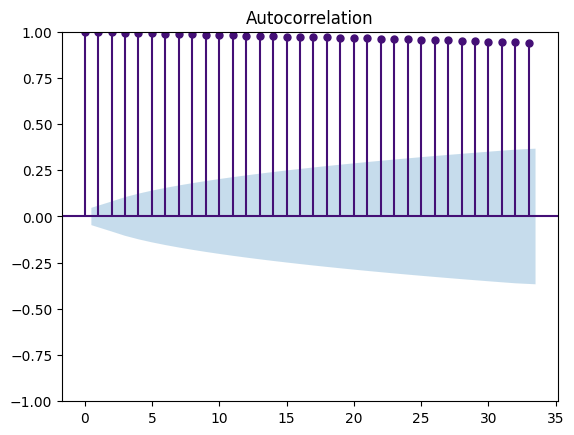

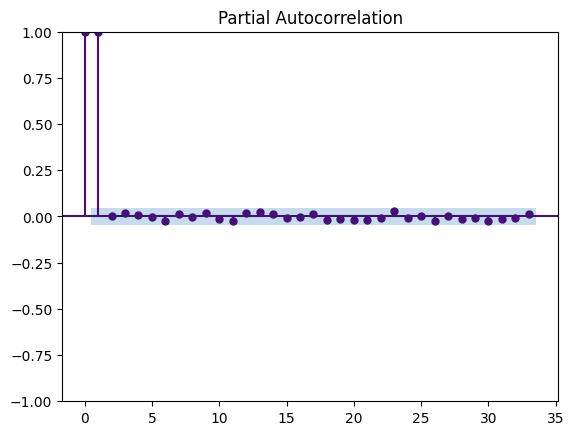

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(df['10yr'], color='#440f76', vlines_kwargs={'color':'#440f76'});
plot_pacf(df['10yr'], color='#440f76', vlines_kwargs={'color':'#440f76'});

## Specify the model*

In [ ]:
from utils.tools import dotdict
from exp.exp_informer import Exp_Informer
import torch

In [ ]:
args = dotdict()

args.model = 'informer' # model of experiment, options: [informer, informerstack, informerlight(TBD)]

args.data = 'custom' # data
args.root_path = '/content/' # root path of data file
args.data_path = 'daily-treasury-rates.csv' # data file
args.features = 'MS' # forecasting task, options:[M, S, MS]; M:multivariate predict multivariate, S:univariate predict univariate, MS:multivariate predict univariate
args.target = '10yr' # target feature in S or MS task
args.cols = ['7yr', '10yr', '20yr']
args.freq = 'b' # freq for time features encoding, options:[s:secondly, t:minutely, h:hourly, d:daily, b:business days, w:weekly, m:monthly], you can also use more detailed freq like 15min or 3h
args.checkpoints = './informer_checkpoints' # location of model checkpoints

args.seq_len = 90 # input sequence length of Informer encoder
args.label_len = 5 # start token length of Informer decoder
args.pred_len = 21 # prediction sequence length
# Informer decoder input: concat[start token series(label_len), zero padding series(pred_len)]

args.enc_in = len(args.cols) # encoder input size
args.dec_in = len(args.cols) # decoder input size
args.c_out = 1 # output size

args.factor = 5 # probsparse attn factor
args.d_model = 512 # dimension of model
args.n_heads = 8 # num of heads
args.e_layers = 2 # num of encoder layers
args.d_layers = 1 # num of decoder layers

args.d_ff = 2048 # dimension of fcn in model
args.dropout = 0.1 # dropout
args.attn = 'prob' # attention used in encoder, options:[prob, full]

args.embed = 'timeF' # time features encoding, options:[timeF, fixed, learned]
args.activation = 'gelu' # activation
args.distil = True # whether to use distilling in encoder
args.output_attention = True # whether to output attention in encoder
args.mix = True
args.inverse = True
args.padding = 0

args.batch_size = 32
args.learning_rate = 0.0001
args.loss = 'mse'
args.lradj = 'type1'
args.use_amp = False # whether to use automatic mixed precision training

args.num_workers = 0
args.itr = 5
args.train_epochs = 10
args.patience = 3
args.des = 'exp'

args.use_gpu = True if torch.cuda.is_available() else False
args.gpu = 0

args.use_multi_gpu = False
args.devices = '0,1,2,3'


In [ ]:
args.use_gpu = True if torch.cuda.is_available() and args.use_gpu else False

if args.use_gpu and args.use_multi_gpu:
    args.devices = args.devices.replace(' ','')
    device_ids = args.devices.split(',')
    args.device_ids = [int(id_) for id_ in device_ids]
    args.gpu = args.device_ids[0]

In [ ]:
holidays25 = holidays.NYSE(years=[2025])
holidays25.pop(date(2025, 1, 9)) # National Day of Mourning for former President Jimmy Carter is an observed day
bday_only = pd.offsets.CustomBusinessDay(holidays=holidays25)
args.detail_freq = bday_only
args.freq = args.freq[-1:]

In [ ]:
print('Args in experiment:')
print(args)

Args in experiment:
{'model': 'informer', 'data': 'custom', 'root_path': '/content/', 'data_path': 'daily-treasury-rates.csv', 'features': 'MS', 'target': '10yr', 'cols': ['7yr', '10yr', '20yr'], 'freq': 'b', 'checkpoints': './informer_checkpoints', 'seq_len': 90, 'label_len': 5, 'pred_len': 21, 'enc_in': 3, 'dec_in': 3, 'c_out': 1, 'factor': 5, 'd_model': 512, 'n_heads': 8, 'e_layers': 2, 'd_layers': 1, 'd_ff': 2048, 'dropout': 0.1, 'attn': 'prob', 'embed': 'timeF', 'activation': 'gelu', 'distil': True, 'output_attention': True, 'mix': True, 'inverse': True, 'padding': 0, 'batch_size': 32, 'learning_rate': 0.0001, 'loss': 'mse', 'lradj': 'type1', 'use_amp': False, 'num_workers': 0, 'itr': 5, 'train_epochs': 10, 'patience': 3, 'des': 'exp', 'use_gpu': True, 'gpu': 0, 'use_multi_gpu': False, 'devices': '0,1,2,3', 'detail_freq': <CustomBusinessDay>}


In [ ]:
Exp = Exp_Informer

## Prepare our data for training

In [ ]:
exp = Exp(args)
for_train, _ = exp._get_data(flag='train')
for_val, _ = exp._get_data(flag='val')
for_test, _ = exp._get_data(flag='test')
for_pred, _ = exp._get_data(flag='pred')

Use GPU: cuda:0
train 1115
val 155
test 330
pred 1


In [ ]:
num_train = int(len(df)*0.7); print(num_train)
num_test = int(len(df)*0.2); print(num_test)
num_vali = len(df) - num_train - num_test; print(num_vali)
border1s = [0, num_train-args.seq_len, len(df)-num_test-args.seq_len]
border2s = [num_train, num_train+num_vali, len(df)]
print(border1s)
print(border2s)

1225
350
175
[0, 1135, 1310]
[1225, 1400, 1750]


In [ ]:
for_train.data_x.shape, for_val.data_x.shape, for_test.data_x.shape, for_pred.data_x.shape

((1225, 3), (265, 3), (440, 3), (90, 3))

In [ ]:
data_lists = [for_train.data_x, for_val.data_x, for_test.data_x]
fig = go.Figure()
for i, fl in enumerate(['train', 'validation', 'test']):
  fig.add_trace(go.Scatter(x=df.date.iloc[border1s[i]:border2s[i]],
                           y=data_lists[i][:, 2], mode='lines', name=fl,
                           line=dict(color=px.colors.sequential.Magma[3*i+1])))
fig

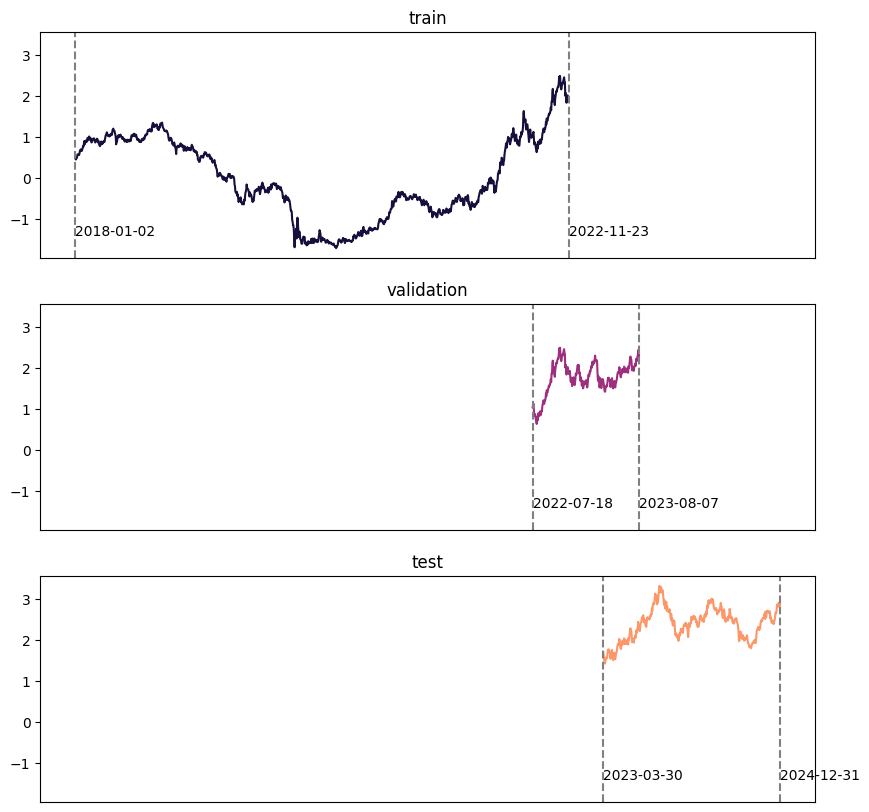

In [ ]:
_, ax = plt.subplots(3, 1, figsize=(10,10), sharex=True, sharey=True)
for i, fl in enumerate(['train', 'validation', 'test']):
    dates = df.date.iloc[border1s[i]:border2s[i]].values
    ax[i].plot(dates, data_lists[i][:, 2], color=px.colors.sequential.Magma[3*i+1])
    ax[i].set_xticks(ticks=[])
    ax[i].axvline(x=dates[0], linestyle='dashed', color='grey')
    ax[i].axvline(x=dates[-1], linestyle='dashed', color='grey')
    ax[i].text(x=dates[0], y=-1.4, s=dates[0])
    ax[i].text(x=dates[-1], y=-1.4, s=dates[-1])
    ax[i].set_title(fl);

## Train the model

In [ ]:
for ii in range(args.itr):
    # setting record of experiments
    setting = '{}_{}_ft{}_sl{}_ll{}_pl{}_dm{}_nh{}_el{}_dl{}_df{}_at{}_fc{}_eb{}_dt{}_mx{}_{}_{}'.format(args.model, args.data, args.features,
                args.seq_len, args.label_len, args.pred_len,
                args.d_model, args.n_heads, args.e_layers, args.d_layers, args.d_ff, args.attn, args.factor, args.embed, args.distil, args.mix, args.des, ii)

    # set experiments
    exp = Exp(args)

    # train
    print('>>>>>>>start training : {}>>>>>>>>>>>>>>>>>>>>>>>>>>'.format(setting))
    exp.train(setting)

    # test
    print('>>>>>>>testing : {}<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<'.format(setting))
    exp.test(setting)

    torch.cuda.empty_cache()

Use GPU: cuda:0
>>>>>>>start training : informer_custom_ftMS_sl90_ll5_pl21_dm512_nh8_el2_dl1_df2048_atprob_fc5_ebtimeF_dtTrue_mxTrue_exp_0>>>>>>>>>>>>>>>>>>>>>>>>>>
train 1115
val 155
test 330
Epoch: 1 cost time: 4.639917373657227
Epoch: 1, Steps: 34 | Train Loss: 0.2333606 Vali Loss: 0.1030097 Test Loss: 0.4288417
Validation loss decreased (inf --> 0.103010).  Saving model ...
Updating learning rate to 0.0001
Epoch: 2 cost time: 2.2967658042907715
Epoch: 2, Steps: 34 | Train Loss: 0.0701090 Vali Loss: 0.0532782 Test Loss: 0.1811876
Validation loss decreased (0.103010 --> 0.053278).  Saving model ...
Updating learning rate to 5e-05
Epoch: 3 cost time: 2.2639083862304688
Epoch: 3, Steps: 34 | Train Loss: 0.0526566 Vali Loss: 0.0422668 Test Loss: 0.2258047
Validation loss decreased (0.053278 --> 0.042267).  Saving model ...
Updating learning rate to 2.5e-05
Epoch: 4 cost time: 2.3999011516571045
Epoch: 4, Steps: 34 | Train Loss: 0.0495480 Vali Loss: 0.0585588 Test Loss: 0.1483380
EarlySt

In [ ]:
exp.model

Informer(
  (enc_embedding): DataEmbedding(
    (value_embedding): TokenEmbedding(
      (tokenConv): Conv1d(3, 512, kernel_size=(3,), stride=(1,), padding=(1,), padding_mode=circular)
    )
    (position_embedding): PositionalEmbedding()
    (temporal_embedding): TimeFeatureEmbedding(
      (embed): Linear(in_features=3, out_features=512, bias=True)
    )
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (dec_embedding): DataEmbedding(
    (value_embedding): TokenEmbedding(
      (tokenConv): Conv1d(3, 512, kernel_size=(3,), stride=(1,), padding=(1,), padding_mode=circular)
    )
    (position_embedding): PositionalEmbedding()
    (temporal_embedding): TimeFeatureEmbedding(
      (embed): Linear(in_features=3, out_features=512, bias=True)
    )
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): Encoder(
    (attn_layers): ModuleList(
      (0-1): 2 x EncoderLayer(
        (attention): AttentionLayer(
          (inner_attention): ProbAttention(
            (dropout): Dropou

In [ ]:
print("Model's state_dict:")
for param_tensor in exp.model.state_dict():
    print(param_tensor, "\t", exp.model.state_dict()[param_tensor].size())

Model's state_dict:
enc_embedding.value_embedding.tokenConv.weight 	 torch.Size([512, 3, 3])
enc_embedding.value_embedding.tokenConv.bias 	 torch.Size([512])
enc_embedding.position_embedding.pe 	 torch.Size([1, 5000, 512])
enc_embedding.temporal_embedding.embed.weight 	 torch.Size([512, 3])
enc_embedding.temporal_embedding.embed.bias 	 torch.Size([512])
dec_embedding.value_embedding.tokenConv.weight 	 torch.Size([512, 3, 3])
dec_embedding.value_embedding.tokenConv.bias 	 torch.Size([512])
dec_embedding.position_embedding.pe 	 torch.Size([1, 5000, 512])
dec_embedding.temporal_embedding.embed.weight 	 torch.Size([512, 3])
dec_embedding.temporal_embedding.embed.bias 	 torch.Size([512])
encoder.attn_layers.0.attention.query_projection.weight 	 torch.Size([512, 512])
encoder.attn_layers.0.attention.query_projection.bias 	 torch.Size([512])
encoder.attn_layers.0.attention.key_projection.weight 	 torch.Size([512, 512])
encoder.attn_layers.0.attention.key_projection.bias 	 torch.Size([512])
en

## Prediction

In [ ]:
# exp = Exp(args)

# model = exp.model

# path = os.path.join(args.checkpoints,setting,'checkpoint.pth')
# model.load_state_dict(torch.load(path))

In [ ]:
pred_prob = np.zeros((args.pred_len, args.itr))
for ii in range(args.itr):
  setting = '{}_{}_ft{}_sl{}_ll{}_pl{}_dm{}_nh{}_el{}_dl{}_df{}_at{}_fc{}_eb{}_dt{}_mx{}_{}_{}'.format(args.model, args.data, args.features,
                                                                                                       args.seq_len, args.label_len, args.pred_len,
                                                                                                       args.d_model, args.n_heads, args.e_layers, args.d_layers, args.d_ff,
                                                                                                       args.attn, args.factor, args.embed, args.distil, args.mix, args.des, ii)
  # the object exp will load the best model from each iteration
  exp.predict(setting, load=True)

  # the prediction is saved in ./results/{setting}/real_prediction.npy
  # put the prediction in a matrix, which will be used for further analysis
  # the prediction is a 3D array with shape (1, pred_len, 1), and I want to load it as a 1D array instead.
  pred_prob[:, ii] = np.load('./results/'+setting+'/real_prediction.npy')[0, :, 0]

pred 1
pred 1
pred 1
pred 1
pred 1


In [ ]:
# get the prediction dates

from data.data_loader import Dataset_Pred
dataset_pred_recreate = Dataset_Pred(root_path=args.root_path, data_path=args.data_path,
                                     size=[args.seq_len, args.label_len, args.pred_len],
                                     features=args.features, target=args.target,
                                     scale=True, inverse=args.inverse,
                                     timeenc=args.embed, freq=args.detail_freq, cols=args.cols)
pred_dates = dataset_pred_recreate.pred_dates
pred_dates

DatetimeIndex(['2024-12-31', '2025-01-02', '2025-01-03', '2025-01-06',
               '2025-01-07', '2025-01-08', '2025-01-09', '2025-01-10',
               '2025-01-13', '2025-01-14', '2025-01-15', '2025-01-16',
               '2025-01-17', '2025-01-21', '2025-01-22', '2025-01-23',
               '2025-01-24', '2025-01-27', '2025-01-28', '2025-01-29',
               '2025-01-30', '2025-01-31'],
              dtype='datetime64[ns]', freq='C')

## Visualization

In [ ]:
# metrics on the test set
# [mae, mse, rmse, mape, mspe]
np.load('./results/'+setting+'/metrics.npy')

array([0.42942497, 0.2581154 , 0.5080506 , 0.09789955, 0.01289757],
      dtype=float32)

In [ ]:
# When we finished exp.train(setting) and exp.test(setting), we will get a trained model and the results of test experiment
# The results of test experiment will be saved in ./results/{setting}/pred.npy (prediction of test dataset) and ./results/{setting}/true.npy (groundtruth of test dataset)
preds = np.load('./results/'+setting+'/pred.npy')
trues = np.load('./results/'+setting+'/true.npy')

# [samples, pred_len, dimensions]
preds.shape, trues.shape

((320, 21, 1), (320, 21, 1))

### Prediction on the test set

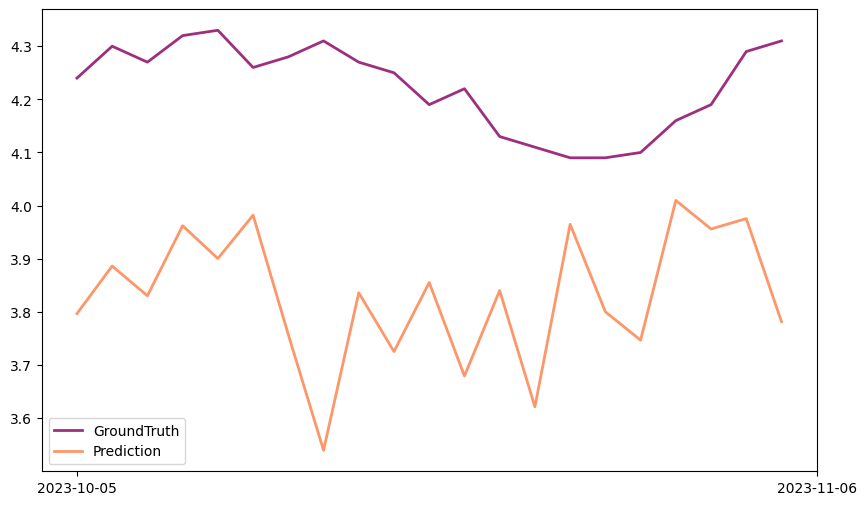

In [ ]:
# draw prediction
rng = np.random.default_rng()
window_num = rng.choice(preds.shape[0])
window_start_id = border1s[2] + window_num
window_end_id = window_start_id + args.pred_len

plt.figure(figsize=(10,6))
plt.plot(df.date.iloc[window_start_id:window_end_id],
         trues[window_num,:,-1], label='GroundTruth',
         color='#9e2f7f', linewidth=2)
plt.plot(preds[window_num,:,-1], label='Prediction',
         color='#fd9668', linewidth=2)
plt.xticks(ticks=df.date.iloc[[window_start_id, window_end_id]])
plt.legend()
plt.show()

### Visualizing attention

In [ ]:
# attention visualization
data_set, data_loader = exp._get_data(flag='train')

idx = 0
for i, (batch_x,batch_y,batch_x_mark,batch_y_mark) in enumerate(data_loader):
    if i!=idx:
        continue
    batch_x = batch_x.float().to(exp.device)
    batch_y = batch_y.float()

    batch_x_mark = batch_x_mark.float().to(exp.device)
    batch_y_mark = batch_y_mark.float().to(exp.device)

    dec_inp = torch.zeros_like(batch_y[:,-args.pred_len:,:]).float()
    dec_inp = torch.cat([batch_y[:,:args.label_len,:], dec_inp], dim=1).float().to(exp.device)

    outputs,attn = exp.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)

train 1115


In [ ]:
attn[0].shape, attn[1].shape #, attn[2].shape

(torch.Size([32, 8, 90, 90]), torch.Size([32, 8, 45, 45]))

In [ ]:
outputs.shape

torch.Size([32, 21, 1])

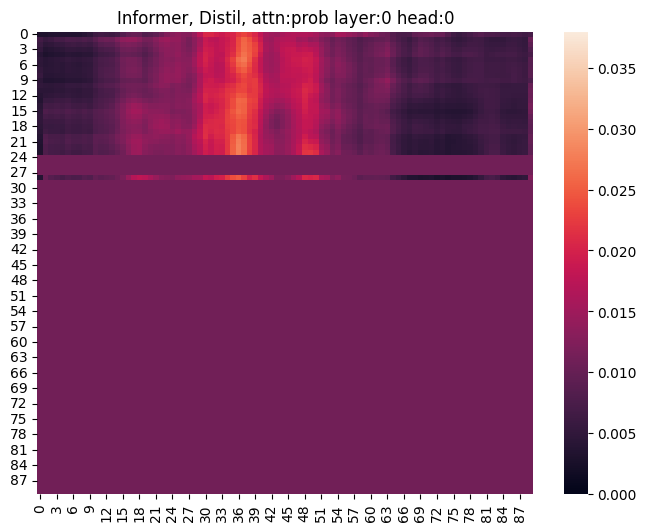

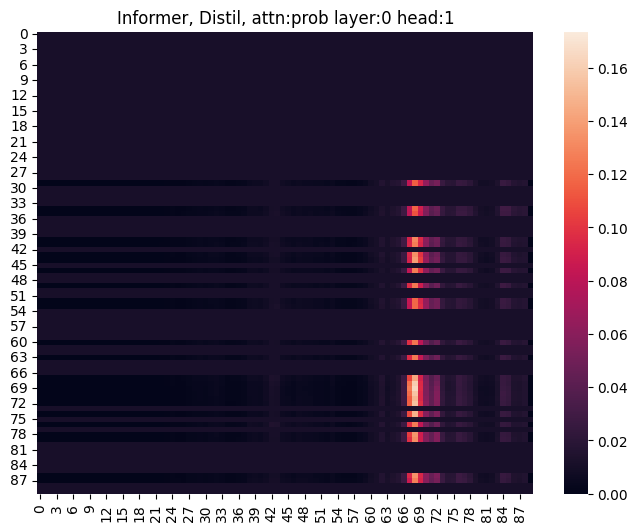

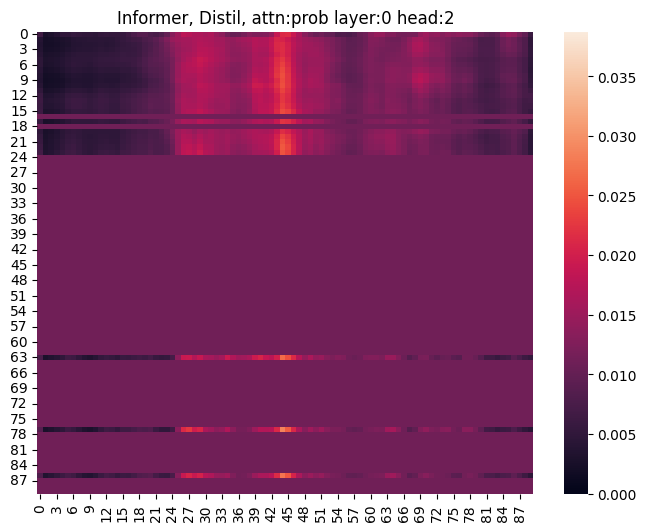

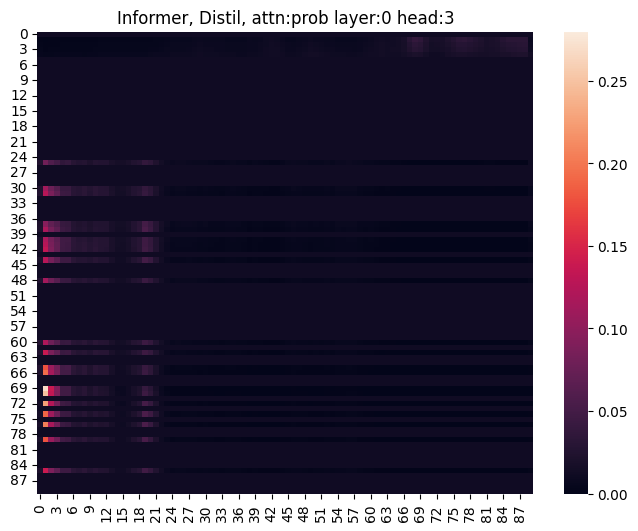

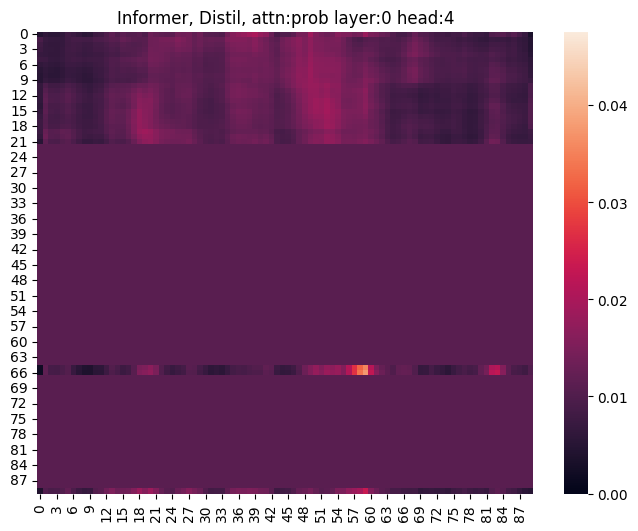

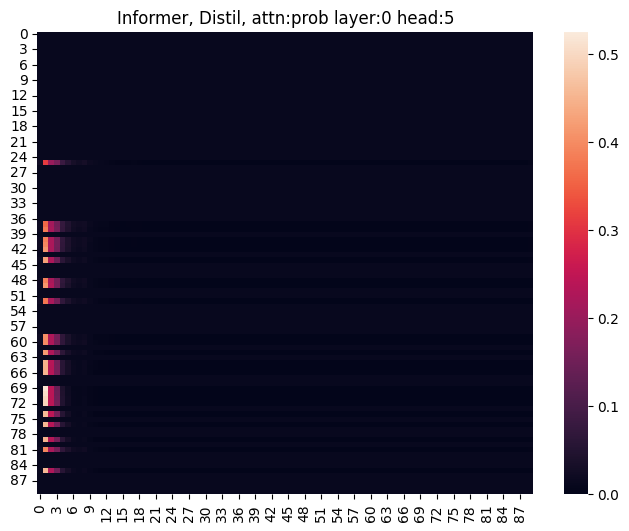

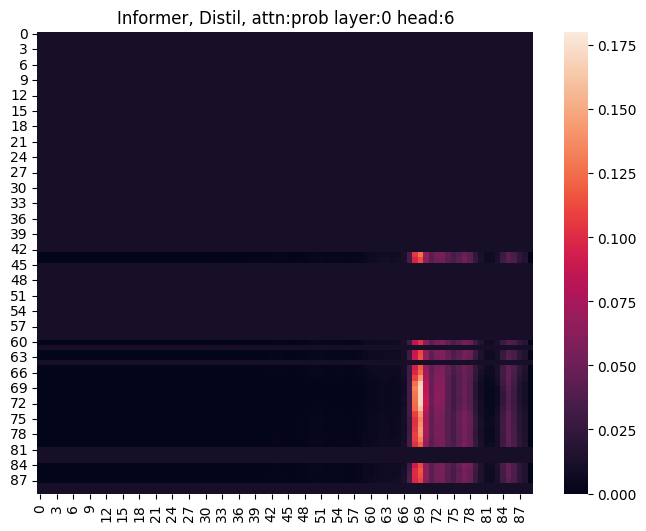

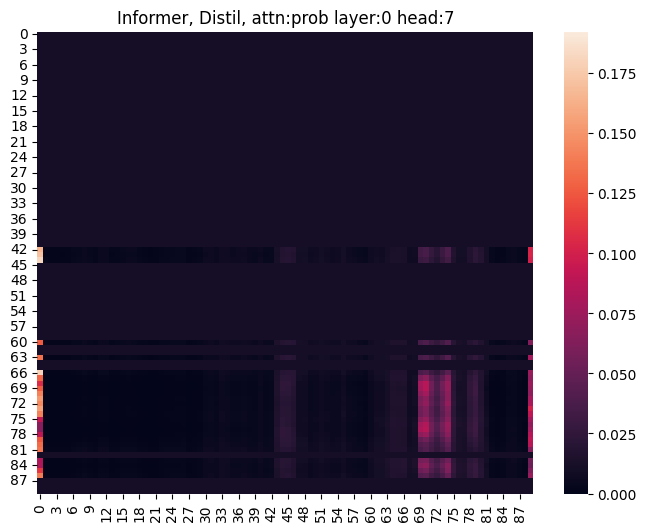

In [ ]:
layer = 0
distil = 'Distil' if args.distil else 'NoDistil'
for h in range(0,8):
    plt.figure(figsize=[8,6])
    plt.title('Informer, {}, attn:{} layer:{} head:{}'.format(distil, args.attn, layer, h))
    A = attn[layer][0,h].detach().cpu().numpy()
    ax = sns.heatmap(A, vmin=0, vmax=A.max()+0.01)
    plt.savefig(f'attn-layer{layer}-head{h}.png', dpi=300)
    plt.show()

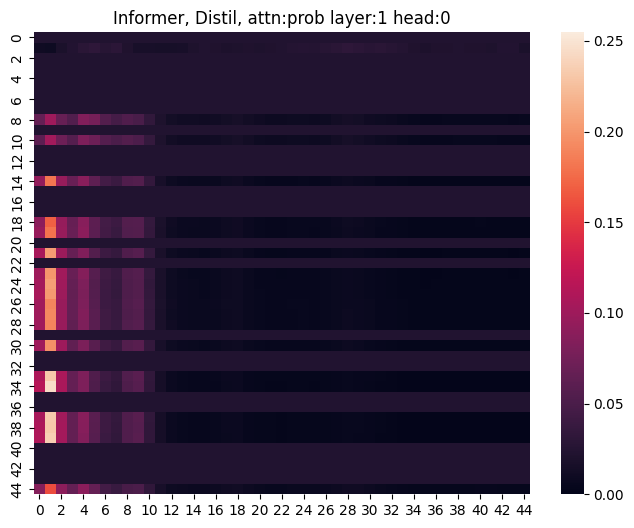

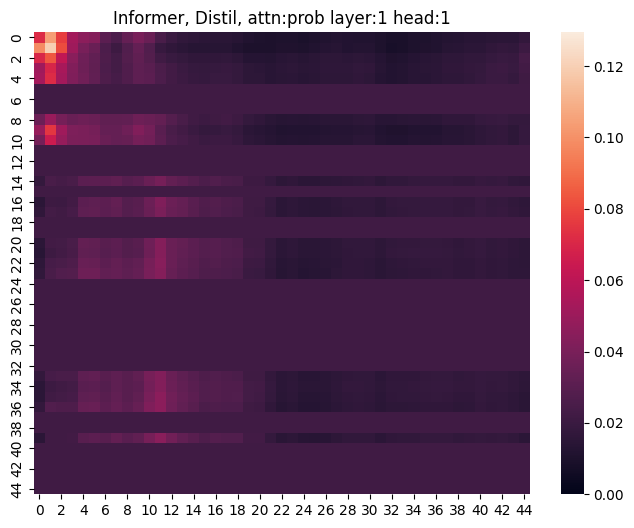

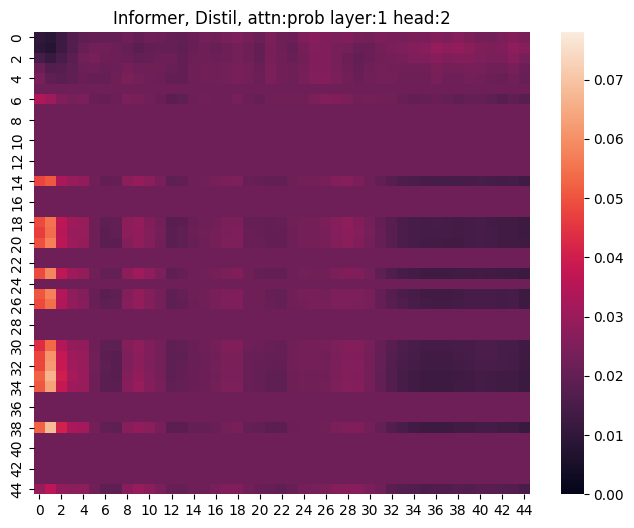

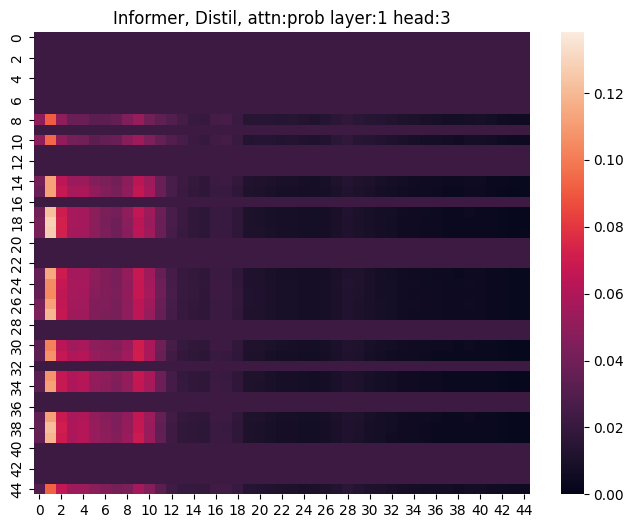

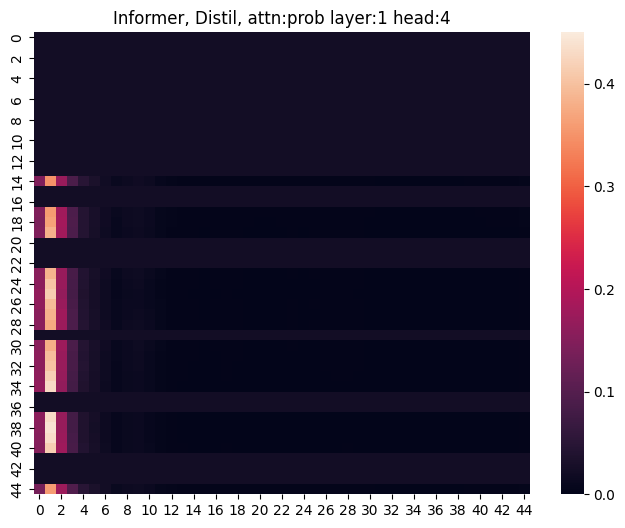

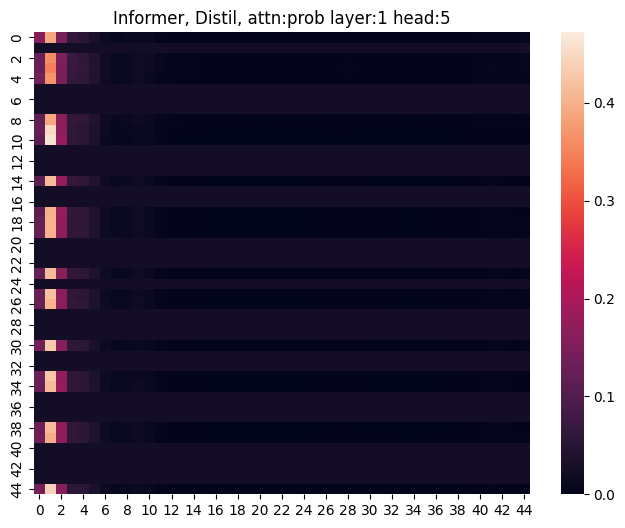

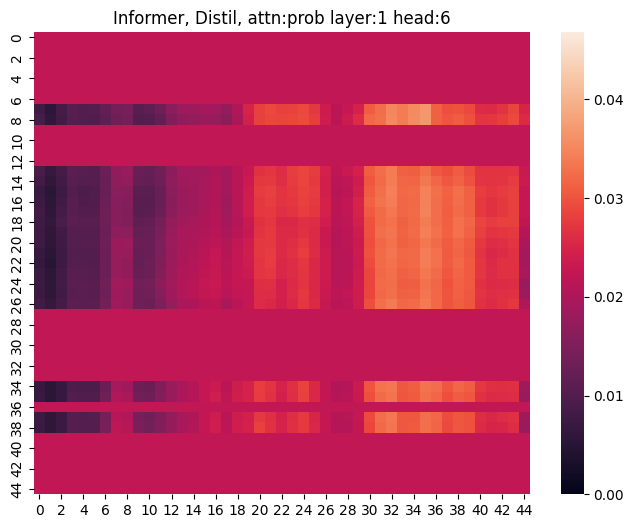

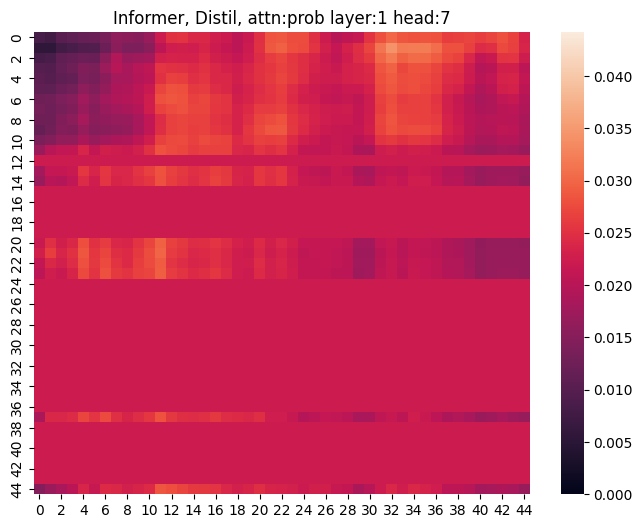

In [ ]:
layer = 1
distil = 'Distil' if args.distil else 'NoDistil'
for h in range(0,8):
    plt.figure(figsize=[8,6])
    plt.title('Informer, {}, attn:{} layer:{} head:{}'.format(distil, args.attn, layer, h))
    A = attn[layer][0,h].detach().cpu().numpy()
    ax = sns.heatmap(A, vmin=0, vmax=A.max()+0.01)
    plt.savefig(f'attn-layer{layer}-head{h}.png', dpi=300)
    plt.show()

# How are we doing so far?*

In [ ]:
yield2025 = pd.read_csv('daily-treasury-rates_2025-Mar.csv', parse_dates=['Date'])
yield2025.sort_values('Date', inplace=True)
yield2025.head()

,Date,1 Mo,1.5 Month,2 Mo,3 Mo,4 Mo,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,30 Yr
60,2025-01-02,4.45,NaN,4.36,4.36,4.31,4.25,4.17,4.25,4.29,4.38,4.47,4.57,4.86,4.79
59,2025-01-03,4.44,NaN,4.35,4.34,4.31,4.25,4.18,4.28,4.32,4.41,4.51,4.60,4.88,4.82
58,2025-01-06,4.43,NaN,4.36,4.35,4.31,4.24,4.17,4.28,4.30,4.42,4.52,4.62,4.91,4.85
57,2025-01-07,4.42,NaN,4.35,4.35,4.31,4.24,4.19,4.30,4.33,4.46,4.57,4.67,4.97,4.91
56,2025-01-08,4.41,NaN,4.34,4.35,4.31,4.25,4.19,4.28,4.31,4.45,4.56,4.67,4.97,4.91


In [ ]:
yield2025.tail()

,Date,1 Mo,1.5 Month,2 Mo,3 Mo,4 Mo,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,30 Yr
4,2025-03-25,4.36,4.34,4.33,4.33,4.30,4.26,4.09,3.96,3.98,4.07,4.19,4.31,4.67,4.65
3,2025-03-26,4.36,4.34,4.33,4.33,4.31,4.26,4.10,3.98,4.01,4.08,4.22,4.35,4.71,4.69
2,2025-03-27,4.37,4.35,4.36,4.33,4.31,4.27,4.10,3.97,4.00,4.09,4.23,4.38,4.75,4.73
1,2025-03-28,4.38,4.35,4.35,4.33,4.30,4.26,4.04,3.89,3.91,3.98,4.11,4.27,4.65,4.64
0,2025-03-31,4.38,4.36,4.35,4.32,4.31,4.23,4.03,3.89,3.89,3.96,4.09,4.23,4.62,4.59


In [ ]:
yield2025.shape

(61, 15)

In [ ]:
truth = yield2025.loc[yield2025.Date.dt.month==1]
mses = np.apply_along_axis(lambda x: np.mean((x-truth['10 Yr'])**2), 0, pred_prob)

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=yield2025.Date, y=yield2025['10 Yr'], mode='markers+lines', name='groundtruth',
                         line=dict(color='gray')))
for ii in range(args.itr):
  fig.add_trace(go.Scatter(x=pred_dates[1:], y=pred_prob[:, ii], mode='markers+lines', name=f'prediction_{ii}',
                           opacity=0.3,
                          line=dict(color='#f2645c'), text=f'MSE: {np.round(mses[ii],3)}'))
fig.add_trace(go.Scatter(x=pred_dates[1:], y=np.mean(pred_prob, axis=1), mode='markers+lines', name=f'predictionProb_avg',
                          line=dict(color='#f2645c')))
fig.update_layout(title=dict(text=f'average MSE: {np.round(np.mean(mses), 3)}',
                             x=0.8, y=0.8))

# Full vs Probsparse Attention

In [ ]:
args.attn = 'full'

In [ ]:
for ii in range(args.itr):
    # setting record of experiments
    setting = '{}_{}_ft{}_sl{}_ll{}_pl{}_dm{}_nh{}_el{}_dl{}_df{}_at{}_fc{}_eb{}_dt{}_mx{}_{}_{}'.format(args.model, args.data, args.features,
                args.seq_len, args.label_len, args.pred_len,
                args.d_model, args.n_heads, args.e_layers, args.d_layers, args.d_ff, args.attn, args.factor, args.embed, args.distil, args.mix, args.des, ii)

    # set experiments
    exp = Exp(args)

    # train
    print('>>>>>>>start training : {}>>>>>>>>>>>>>>>>>>>>>>>>>>'.format(setting))
    exp.train(setting)

    # test
    print('>>>>>>>testing : {}<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<'.format(setting))
    exp.test(setting)

    torch.cuda.empty_cache()

Use GPU: cuda:0
>>>>>>>start training : informer_custom_ftMS_sl90_ll5_pl21_dm512_nh8_el2_dl1_df2048_atfull_fc5_ebtimeF_dtTrue_mxTrue_exp_0>>>>>>>>>>>>>>>>>>>>>>>>>>
train 1115
val 155
test 330
Epoch: 1 cost time: 2.0499510765075684
Epoch: 1, Steps: 34 | Train Loss: 0.1735982 Vali Loss: 0.2282954 Test Loss: 0.7348757
Validation loss decreased (inf --> 0.228295).  Saving model ...
Updating learning rate to 0.0001
Epoch: 2 cost time: 2.0017497539520264
Epoch: 2, Steps: 34 | Train Loss: 0.0632785 Vali Loss: 0.0522812 Test Loss: 0.1910374
Validation loss decreased (0.228295 --> 0.052281).  Saving model ...
Updating learning rate to 5e-05
Epoch: 3 cost time: 2.020826578140259
Epoch: 3, Steps: 34 | Train Loss: 0.0427132 Vali Loss: 0.0488804 Test Loss: 0.1737410
Validation loss decreased (0.052281 --> 0.048880).  Saving model ...
Updating learning rate to 2.5e-05
Epoch: 4 cost time: 2.0356595516204834
Epoch: 4, Steps: 34 | Train Loss: 0.0380012 Vali Loss: 0.0670319 Test Loss: 0.1026119
EarlySt

In [ ]:
pred_full = np.zeros((args.pred_len, args.itr))
for ii in range(args.itr):
  setting = '{}_{}_ft{}_sl{}_ll{}_pl{}_dm{}_nh{}_el{}_dl{}_df{}_at{}_fc{}_eb{}_dt{}_mx{}_{}_{}'.format(args.model, args.data, args.features,
                                                                                                       args.seq_len, args.label_len, args.pred_len,
                                                                                                       args.d_model, args.n_heads, args.e_layers, args.d_layers, args.d_ff,
                                                                                                       args.attn, args.factor, args.embed, args.distil, args.mix, args.des, ii)
  # the object exp will load the best model from each iteration
  exp.predict(setting, load=True)

  # the prediction is saved in ./results/{setting}/real_prediction.npy
  # put the prediction in a matrix, which will be used for further analysis
  # the prediction is a 3D array with shape (1, pred_len, 1), and I want to load it as a 1D array instead.
  pred_full[:, ii] = np.load('./results/'+setting+'/real_prediction.npy')[0, :, 0]
  print(pred_full[:, ii].shape)

pred 1
(21,)
pred 1
(21,)
pred 1
(21,)
pred 1
(21,)
pred 1
(21,)


In [ ]:
truth = yield2025.loc[yield2025.Date.dt.month==1]
mses = np.apply_along_axis(lambda x: np.mean((x-truth['10 Yr'])**2), 0, pred_full)

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=yield2025.Date, y=yield2025['10 Yr'], mode='markers+lines', name='groundtruth',
                         line=dict(color='gray')))
fig.add_trace(go.Scatter(x=pred_dates[1:], y=np.mean(pred_prob, axis=1), mode='markers+lines', name=f'predictionProb_avg',
                          line=dict(color='#f2645c')))


for ii in range(args.itr):
  fig.add_trace(go.Scatter(x=pred_dates[1:], y=pred_full[:, ii], mode='markers+lines', name=f'prediction_{ii}',
                           opacity=0.3,
                          line=dict(color='#842681'), text=f'MSE: {np.round(mses[ii],3)}'))
fig.add_trace(go.Scatter(x=pred_dates[1:], y=np.mean(pred_full, axis=1), mode='markers+lines', name=f'predictionFull_avg',
                          line=dict(color='#842681')))
fig.update_layout(title=dict(text=f'average MSE: {np.round(np.mean(mses), 3)}',
                             x=0.8, y=0.8))

# Play around with the horizon (`pred_len`)

## Five days ahead

In [ ]:
args.data = 'custom' # data
args.root_path = '/content/' # root path of data file
args.data_path = 'daily-treasury-rates.csv' # data file
args.features = 'MS' # forecasting task, options:[M, S, MS]; M:multivariate predict multivariate, S:univariate predict univariate, MS:multivariate predict univariate
args.target = '10yr' # target feature in S or MS task
args.cols = ['7yr', '10yr', '20yr']

args.seq_len = 90 # input sequence length of Informer encoder
args.label_len = 5 # start token length of Informer decoder
args.pred_len = 5 # prediction sequence length

args.enc_in = len(args.cols) # encoder input size
args.dec_in = len(args.cols) # decoder input size
args.c_out = 1 # output size
args.attn = 'prob'
args.itr = 1

In [ ]:
args.use_gpu = True if torch.cuda.is_available() and args.use_gpu else False

if args.use_gpu and args.use_multi_gpu:
    args.devices = args.devices.replace(' ','')
    device_ids = args.devices.split(',')
    args.device_ids = [int(id_) for id_ in device_ids]
    args.gpu = args.device_ids[0]

In [ ]:
print('Args in experiment:')
print(args)

Args in experiment:
{'model': 'informer', 'data': 'custom', 'root_path': '/content/', 'data_path': 'daily-treasury-rates.csv', 'features': 'MS', 'target': '10yr', 'cols': ['7yr', '10yr', '20yr'], 'freq': 'b', 'checkpoints': './informer_checkpoints', 'seq_len': 90, 'label_len': 5, 'pred_len': 5, 'enc_in': 3, 'dec_in': 3, 'c_out': 1, 'factor': 5, 'd_model': 512, 'n_heads': 8, 'e_layers': 2, 'd_layers': 1, 'd_ff': 2048, 'dropout': 0.1, 'attn': 'prob', 'embed': 'timeF', 'activation': 'gelu', 'distil': True, 'output_attention': True, 'mix': True, 'inverse': True, 'padding': 0, 'batch_size': 32, 'learning_rate': 0.0001, 'loss': 'mse', 'lradj': 'type1', 'use_amp': False, 'num_workers': 0, 'itr': 1, 'train_epochs': 10, 'patience': 3, 'des': 'exp', 'use_gpu': True, 'gpu': 0, 'use_multi_gpu': False, 'devices': '0,1,2,3', 'detail_freq': <CustomBusinessDay>}


In [ ]:
for ii in range(args.itr):
    # setting record of experiments
    setting = '{}_{}_ft{}_sl{}_ll{}_pl{}_dm{}_nh{}_el{}_dl{}_df{}_at{}_fc{}_eb{}_dt{}_mx{}_{}_{}'.format(args.model, args.data, args.features,
                args.seq_len, args.label_len, args.pred_len,
                args.d_model, args.n_heads, args.e_layers, args.d_layers, args.d_ff, args.attn, args.factor, args.embed, args.distil, args.mix, args.des, ii)

    # set experiments
    exp5d = Exp(args)

    # train
    print('>>>>>>>start training : {}>>>>>>>>>>>>>>>>>>>>>>>>>>'.format(setting))
    exp5d.train(setting)

    # test
    print('>>>>>>>testing : {}<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<'.format(setting))
    exp5d.test(setting)

    torch.cuda.empty_cache()

Use GPU: cuda:0
>>>>>>>start training : informer_custom_ftMS_sl90_ll5_pl5_dm512_nh8_el2_dl1_df2048_atprob_fc5_ebtimeF_dtTrue_mxTrue_exp_0>>>>>>>>>>>>>>>>>>>>>>>>>>
train 1131
val 171
test 346
Epoch: 1 cost time: 2.3463551998138428
Epoch: 1, Steps: 35 | Train Loss: 0.1498733 Vali Loss: 0.0758355 Test Loss: 0.1120314
Validation loss decreased (inf --> 0.075835).  Saving model ...
Updating learning rate to 0.0001
Epoch: 2 cost time: 2.2767741680145264
Epoch: 2, Steps: 35 | Train Loss: 0.0376412 Vali Loss: 0.0451814 Test Loss: 0.0633065
Validation loss decreased (0.075835 --> 0.045181).  Saving model ...
Updating learning rate to 5e-05
Epoch: 3 cost time: 2.385347604751587
Epoch: 3, Steps: 35 | Train Loss: 0.0285443 Vali Loss: 0.0998163 Test Loss: 0.0434288
EarlyStopping counter: 1 out of 3
Updating learning rate to 2.5e-05
Epoch: 4 cost time: 2.2906253337860107
Epoch: 4, Steps: 35 | Train Loss: 0.0245484 Vali Loss: 0.0730176 Test Loss: 0.0388893
EarlyStopping counter: 2 out of 3
Updating 

In [ ]:
exp5d.predict(setting, load=True)
prediction5d = np.load('./results/'+setting+'/real_prediction.npy')
prediction5d.shape

pred 1


(1, 5, 1)

In [ ]:
# get the prediction dates
dataset_pred_recreate = Dataset_Pred(root_path=args.root_path, data_path=args.data_path,
                                     size=[args.seq_len, args.label_len, args.pred_len],
                                     features=args.features, target=args.target,
                                     scale=True, inverse=args.inverse,
                                     timeenc=args.embed, freq=args.detail_freq, cols=args.cols)
pred_dates = dataset_pred_recreate.pred_dates
pred_dates

DatetimeIndex(['2024-12-31', '2025-01-02', '2025-01-03', '2025-01-06',
               '2025-01-07', '2025-01-08'],
              dtype='datetime64[ns]', freq='C')

In [ ]:
# calculate MSE
truth = yield2025.iloc[:args.pred_len, :]
mse = np.mean((prediction5d[0,:,-1]-truth['10 Yr'])**2)
mse

np.float64(0.025348576804757543)

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=yield2025.Date, y=yield2025['10 Yr'], mode='markers+lines', name='groundtruth',
                         line=dict(color='gray')))
fig.add_trace(go.Scatter(x=yield2025.Date.iloc[:21], y=np.mean(pred_prob, axis=1), mode='markers+lines',
                         name=f'predictionProb_avg', line=dict(color='#f2645c')))
fig.add_trace(go.Scatter(x=pred_dates[1:], y=prediction5d[0,:,-1], mode='markers+lines', name='prediction5d',
                         line=dict(color='#842681'), text=f'MSE: {np.round(mse,3)}'))

## Ten days ahead

In [ ]:
args.seq_len = 90 # input sequence length of Informer encoder
args.label_len = 5 # start token length of Informer decoder
args.pred_len = 10 # prediction sequence length

In [ ]:
for ii in range(args.itr):
    # setting record of experiments
    setting = '{}_{}_ft{}_sl{}_ll{}_pl{}_dm{}_nh{}_el{}_dl{}_df{}_at{}_fc{}_eb{}_dt{}_mx{}_{}_{}'.format(args.model, args.data, args.features,
                args.seq_len, args.label_len, args.pred_len,
                args.d_model, args.n_heads, args.e_layers, args.d_layers, args.d_ff, args.attn, args.factor, args.embed, args.distil, args.mix, args.des, ii)

    # set experiments
    exp10d = Exp(args)

    # train
    print('>>>>>>>start training : {}>>>>>>>>>>>>>>>>>>>>>>>>>>'.format(setting))
    exp10d.train(setting)

    # test
    print('>>>>>>>testing : {}<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<'.format(setting))
    exp10d.test(setting)

    torch.cuda.empty_cache()

Use GPU: cuda:0
>>>>>>>start training : informer_custom_ftMS_sl90_ll5_pl10_dm512_nh8_el2_dl1_df2048_atprob_fc5_ebtimeF_dtTrue_mxTrue_exp_0>>>>>>>>>>>>>>>>>>>>>>>>>>
train 1126
val 166
test 341
Epoch: 1 cost time: 2.3233909606933594
Epoch: 1, Steps: 35 | Train Loss: 0.1790222 Vali Loss: 0.0470479 Test Loss: 0.2157658
Validation loss decreased (inf --> 0.047048).  Saving model ...
Updating learning rate to 0.0001
Epoch: 2 cost time: 2.4307782649993896
Epoch: 2, Steps: 35 | Train Loss: 0.0446872 Vali Loss: 0.0514261 Test Loss: 0.0906653
EarlyStopping counter: 1 out of 3
Updating learning rate to 5e-05
Epoch: 3 cost time: 2.3090202808380127
Epoch: 3, Steps: 35 | Train Loss: 0.0326452 Vali Loss: 0.0671746 Test Loss: 0.0544732
EarlyStopping counter: 2 out of 3
Updating learning rate to 2.5e-05
Epoch: 4 cost time: 2.297213077545166
Epoch: 4, Steps: 35 | Train Loss: 0.0290123 Vali Loss: 0.0527810 Test Loss: 0.0535241
EarlyStopping counter: 3 out of 3
Early stopping
>>>>>>>testing : informer_cu

In [ ]:
exp10d.predict(setting, load=True)
prediction10d = np.load('./results/'+setting+'/real_prediction.npy')
prediction10d.shape

pred 1


(1, 10, 1)

In [ ]:
# get the prediction dates
dataset_pred_recreate = Dataset_Pred(root_path=args.root_path, data_path=args.data_path,
                                     size=[args.seq_len, args.label_len, args.pred_len],
                                     features=args.features, target=args.target,
                                     scale=True, inverse=args.inverse,
                                     timeenc=args.embed, freq=args.detail_freq, cols=args.cols)
pred_dates = dataset_pred_recreate.pred_dates
pred_dates

DatetimeIndex(['2024-12-31', '2025-01-02', '2025-01-03', '2025-01-06',
               '2025-01-07', '2025-01-08', '2025-01-09', '2025-01-10',
               '2025-01-13', '2025-01-14', '2025-01-15'],
              dtype='datetime64[ns]', freq='C')

In [ ]:
# calculate MSE
truth = yield2025.iloc[:args.pred_len, :]
mse = np.mean((prediction10d[0,:,-1]-truth['10 Yr'])**2)
mse

np.float64(0.09399492068228554)

In [ ]:
fig.add_trace(go.Scatter(x=pred_dates[1:], y=prediction10d[0,:,-1], mode='markers+lines', name='prediction10d',
                         line=dict(color='#ba3878'), text=f'MSE: {np.round(mse,3)}'))

## Three months ahead

In [ ]:
args.seq_len = 120 # input sequence length of Informer encoder
args.label_len = 5 # start token length of Informer decoder
args.pred_len = yield2025.shape[0] # prediction sequence length

In [ ]:
yield2025.shape[0]

61

In [ ]:
for ii in range(args.itr):
    # setting record of experiments
    setting = '{}_{}_ft{}_sl{}_ll{}_pl{}_dm{}_nh{}_el{}_dl{}_df{}_at{}_fc{}_eb{}_dt{}_mx{}_{}_{}'.format(args.model, args.data, args.features,
                args.seq_len, args.label_len, args.pred_len,
                args.d_model, args.n_heads, args.e_layers, args.d_layers, args.d_ff, args.attn, args.factor, args.embed, args.distil, args.mix, args.des, ii)

    # set experiments
    exp45d = Exp(args)

    # train
    print('>>>>>>>start training : {}>>>>>>>>>>>>>>>>>>>>>>>>>>'.format(setting))
    exp45d.train(setting)

    # test
    print('>>>>>>>testing : {}<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<'.format(setting))
    exp45d.test(setting)

    torch.cuda.empty_cache()

Use GPU: cuda:0
>>>>>>>start training : informer_custom_ftMS_sl120_ll5_pl61_dm512_nh8_el2_dl1_df2048_atprob_fc5_ebtimeF_dtTrue_mxTrue_exp_0>>>>>>>>>>>>>>>>>>>>>>>>>>
train 1045
val 115
test 290
Epoch: 1 cost time: 3.071704387664795
Epoch: 1, Steps: 32 | Train Loss: 0.3020956 Vali Loss: 0.2945016 Test Loss: 0.9657138
Validation loss decreased (inf --> 0.294502).  Saving model ...
Updating learning rate to 0.0001
Epoch: 2 cost time: 3.0870208740234375
Epoch: 2, Steps: 32 | Train Loss: 0.1145384 Vali Loss: 0.2186748 Test Loss: 1.0069469
Validation loss decreased (0.294502 --> 0.218675).  Saving model ...
Updating learning rate to 5e-05
Epoch: 3 cost time: 3.045653820037842
Epoch: 3, Steps: 32 | Train Loss: 0.0691078 Vali Loss: 0.1042796 Test Loss: 0.7510535
Validation loss decreased (0.218675 --> 0.104280).  Saving model ...
Updating learning rate to 2.5e-05
Epoch: 4 cost time: 3.0427496433258057
Epoch: 4, Steps: 32 | Train Loss: 0.0563644 Vali Loss: 0.1153392 Test Loss: 0.7627821
EarlySt

In [ ]:
exp45d.predict(setting, load=True)
prediction45d = np.load('./results/'+setting+'/real_prediction.npy')
prediction45d.shape

pred 1


(1, 61, 1)

In [ ]:
# get the prediction dates
dataset_pred_recreate = Dataset_Pred(root_path=args.root_path, data_path=args.data_path,
                                     size=[args.seq_len, args.label_len, args.pred_len],
                                     features=args.features, target=args.target,
                                     scale=True, inverse=args.inverse,
                                     timeenc=args.embed, freq=args.detail_freq, cols=args.cols)
pred_dates = dataset_pred_recreate.pred_dates
pred_dates

DatetimeIndex(['2024-12-31', '2025-01-02', '2025-01-03', '2025-01-06',
               '2025-01-07', '2025-01-08', '2025-01-09', '2025-01-10',
               '2025-01-13', '2025-01-14', '2025-01-15', '2025-01-16',
               '2025-01-17', '2025-01-21', '2025-01-22', '2025-01-23',
               '2025-01-24', '2025-01-27', '2025-01-28', '2025-01-29',
               '2025-01-30', '2025-01-31', '2025-02-03', '2025-02-04',
               '2025-02-05', '2025-02-06', '2025-02-07', '2025-02-10',
               '2025-02-11', '2025-02-12', '2025-02-13', '2025-02-14',
               '2025-02-18', '2025-02-19', '2025-02-20', '2025-02-21',
               '2025-02-24', '2025-02-25', '2025-02-26', '2025-02-27',
               '2025-02-28', '2025-03-03', '2025-03-04', '2025-03-05',
               '2025-03-06', '2025-03-07', '2025-03-10', '2025-03-11',
               '2025-03-12', '2025-03-13', '2025-03-14', '2025-03-17',
               '2025-03-18', '2025-03-19', '2025-03-20', '2025-03-21',
      

In [ ]:
# calculate MSE
truth = yield2025.iloc[:args.pred_len, :]
mse = np.mean((prediction45d[0,:,-1]-truth['10 Yr'])**2)
mse

np.float64(0.05021589425838972)

In [ ]:
fig.add_trace(go.Scatter(x=pred_dates[1:], y=prediction45d[0,:,-1], mode='markers+lines', name='prediction3m',
                         line=dict(color='#fd9a6a'), text=f'MSE: {np.round(mse,3)}'))

**Thank you very much. Have a nice day!**

---

